#### Functions (IGNORE)

In [1]:
# import packages that will be used for analysis
import random
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

##### Get Stock Data

In [2]:
import yfinance as yf
missing_data_tickers = [] # use this as a list of tickers with missing data

def get_data_from_start_to_end(ticker, start_date, end_date):
    global missing_data_tickers  # Use the global list to accumulate missing tickers
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            missing_data_tickers.append(ticker)
            raise ValueError(f"Stock data for ticker {ticker} during the period from {start_date} to {end_date} was not found.")
        return stock_data
    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")
        missing_data_tickers.append(ticker)
        return None


In [3]:
# for a variety of periods load in different list of tickers
def download_stock_data_for_periods(tickers, periods):
    all_data = {}
    
    for period, (start_date, end_date) in periods.items():
        period_data = {}
        for ticker in tickers:
            data = get_data_from_start_to_end(ticker, start_date, end_date)
            if data is not None:
                period_data[ticker] = data
        all_data[period] = period_data
    
    return all_data

In [4]:
import pandas as pd

# Get the adjusted close prices
adj_close_sector_etf = {}

# Create adjusted close price only listing of sector ETFs
def get_adjusted_closed_price(nested_dict, tickers, periods):
    for period in periods:
        stock_price_df = pd.DataFrame()  # Create a new DataFrame for each period
        for ticker in tickers:
            stock_price_df[ticker] = nested_dict[period][ticker]['Adj Close']
        
        adj_close_sector_etf[period] = stock_price_df  # Store the complete DataFrame for the period
    
    return adj_close_sector_etf

##### Stochastic Modeling

In [5]:
def stochastic_roi(tickers,periods,return_rates_list,analysis_type):
    df = pd.DataFrame(index=tickers,columns=periods)
    for period in periods:
        for ticker in tickers:
            data = pd.Series(return_rates_list[period][ticker])
            if analysis_type=='Mean':
                df.at[ticker,period] = data.mean()
            elif analysis_type=='Median':
                df.at[ticker,period] = data.median()
            elif analysis_type=='Std':
                df.at[ticker,period] = data.std()
            elif analysis_type=='Variance':
                df.at[ticker,period] = data.var()

    return df

##### Bollinger Bands

In [6]:
# create bollinger bands
import scipy.stats as stats
def add_bollinger_data(data,window,conf_int):
        z_score = stats.norm.ppf(1 - (1 - conf_int) / 2) # create a zscore from the mean

        data['middle_band'] = data['Adj Close'].rolling(window).mean()
        data['upper_band'] = data['middle_band'] + z_score * data['Adj Close'].rolling(window).std()
        data['lower_band'] = data['middle_band'] - z_score * data['Adj Close'].rolling(window).std()

        data['Signal'] = None

        data['Signal'] = np.where(data['Adj Close'] < data['lower_band'], 'Buy', 
                              np.where(data['Adj Close'] > data['upper_band'], 'Sell', np.nan))

        return data

In [7]:
# create bollinger data for multiple time period and multiple tickers
def bollinger_data_multiple_periods_tickers(periods,tickers,data,window,confidence_period):
    # for each ticker in economic time periods
    for period in periods:
            for ticker in tickers:
                    try:
                        add_bollinger_data(data[period][ticker],window,confidence_period)
                    except KeyError:
                        print(f'Data for {ticker} does not exist during {period}')
    return data

In [8]:
# create a function that plots the bollinger bands and actions
def plot_with_boll_bands(bollinger_data,title):
    """
    bollinger_data: holds the signals and bollinger data
    """
    buy_data = []
    sell_data = []

    for index, row in bollinger_data.iterrows():
        if row['Signal']=='Buy':
            buy_data.append(row['Adj Close'])
        else:
            buy_data.append(np.nan)

        if row['Signal'] == 'Sell':
            sell_data.append(row['Adj Close'])

        else:
            sell_data.append(np.nan)

    bollinger_data['Buy Data'] = buy_data
    bollinger_data['Sell Data'] = sell_data

    plt.figure(figsize=(12,8))
    
    plt.plot(bollinger_data.index,bollinger_data['Adj Close'],color='grey',label='Adjusted Close Price')
    plt.plot(bollinger_data.index,bollinger_data['lower_band'],color='green',label='Lower Band',linestyle='-')
    plt.plot(bollinger_data.index,bollinger_data['upper_band'],color='red',label='Upper Band',linestyle='-')
    plt.scatter(bollinger_data.index,bollinger_data['Buy Data'],marker='o',color='green',label='Buy Signal')
    plt.scatter(bollinger_data.index,bollinger_data['Sell Data'],marker='o',color='red',label='Sell Signal')

    #plt.plot(investment_tracking_df['Date'],investment_tracking_df['Investment Value'])
    # goal is to make a subplot which shows both the investment and bollinger bands

    plt.xlabel('Date')
    plt.xticks(rotation=60)
    plt.title(title)
    plt.ylabel('Price')
    plt.legend()
    plt.show()

##### Signals

In [9]:
def list_signals(stock_data_with_signals, tickers, periods):
    # Initialize a dictionary to store Buy/Sell signals
    signals_data = {period: {ticker: {'Buy': [], 'Sell': []} for ticker in tickers} for period in periods}

    for period in periods:
        for ticker in tickers:
            # Loop over rows in stock data for the specific period and ticker
            for idx, row in stock_data_with_signals[period][ticker].iterrows():
                if row['Signal'] == 'Buy':
                    # Append the index of the Buy signal
                    signals_data[period][ticker]['Buy'].append(pd.to_datetime(idx))
                elif row['Signal'] == 'Sell':
                    # Append the index of the Sell signal
                    signals_data[period][ticker]['Sell'].append(pd.to_datetime(idx))

    return signals_data

In [10]:
def collect_signals(nested_dict, periods, tickers):
    # Initialize an empty dictionary to hold DataFrames for each period
    bb_nested_dict = {}

    for period in periods:
        # Create a DataFrame for each period with the tickers as columns
        signals_period = pd.DataFrame(columns=tickers)
        
        # Loop through each ticker and extract the 'Signal'
        for ticker in tickers:
            signals_period[ticker] = nested_dict[period][ticker]['Signal']
        
        # Store the DataFrame in the dictionary using the period as the key
        bb_nested_dict[period] = signals_period

    # Return the dictionary containing DataFrames for each period
    return bb_nested_dict

##### Plot data

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot percentage-based histogram
def plot_percentage_histogram(data, title, xlabel, ylabel, bins=10, color='skyblue'):
    """
    Plots a percentage-based histogram for the given data.

    Parameters:
    data (array-like): Data to plot the histogram for.
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    bins (int): Number of bins for the histogram.
    color (str): Color for the histogram bars.
    """
    # Set modern aesthetic
    sns.set_style("whitegrid")

    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, color=color, edgecolor='black',
             weights=np.ones_like(data) / len(data))

    # Convert y-axis to percentages
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

    # Add titles and labels with improved font sizes
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # Add gridlines for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

In [12]:
import matplotlib.pyplot as plt

def plot_sector_investment_changes(sector_allocation, title):

    sector_df = sector_allocation.apply(pd.Series)
    """
    Plots a stacked area chart to track how the investment in different sectors changes over time.

    Parameters:
    sector_df (pd.DataFrame): DataFrame where columns represent sectors and index represents dates.
    title (str): The title of the plot (optional).
    """
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.stackplot(sector_df.index, sector_df.T, labels=sector_df.columns)
    
    # Add title and labels
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Allocation Amount')
    plt.legend(loc='upper left')
    
    # Rotate x-ticks for better readability
    plt.xticks(rotation=45)
    plt.grid()

    # Display the plot
    plt.tight_layout()
    plt.show()

    return sector_df


##### Stock Investment History

In [13]:
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
def individual_stock(bb_signals_nd, adj_close_nd, periods_date, periods_list, tickers, initial_investment, percent_to_buy, percent_to_sell):
    # Portfolio summary - nested dictionary for each period and ticker
    portfolio_summary = {period: {ticker: pd.DataFrame() for ticker in tickers} for period in periods_list}

    # Set data to be accessed
    adj_close_data = adj_close_nd
    bollinger_band_data = bb_signals_nd

    all_data = {
        'Stock Tracker': portfolio_summary,
        'Adjusted Close Price': adj_close_nd,
        'Bollinger Band Signal': bollinger_band_data
    }

    # Loop through each economic period
    for period in periods_list:
        # Create the date range for the current period
        date_range = pd.date_range(start=pd.to_datetime(periods_date[period][0]), end=pd.to_datetime(periods_date[period][1]) - timedelta(days=90))
        # Get random dates for stochastic modeling
        start_dates = np.random.choice(date_range, size=1, replace=False)

        # Loop through sampled start dates
        for start_date in start_dates:
            time_stamp = pd.to_datetime(start_date)

            # Initialize account balance and shares for each ticker
            account_balance = {ticker: initial_investment for ticker in tickers}
            shares_number = {ticker: 0 for ticker in tickers}  # Initialize share count for each ticker

            # Extract the adjusted close and signal data for the time period
            adj_close_period = adj_close_data[period].loc[time_stamp:time_stamp + timedelta(days=120)]
            bb_signals_period = bollinger_band_data[period].loc[time_stamp:time_stamp + timedelta(days=120)]

            # Iterate over each row in the Bollinger Band signals (day by day)
            for row_idx, row in bb_signals_period.iterrows():

                # Tracking for each ticker individually
                for col_idx, signal in enumerate(row):
                    ticker = tickers[col_idx]  # Get ticker for each column
                    adj_close_price = adj_close_period.loc[row_idx, ticker]  # Get adjusted close price for that ticker

                    # Initialize stock tracker for current ticker
                    stock_tracker = all_data['Stock Tracker'][period][ticker]

                    # Handle Buy action
                    if signal == 'Buy':
                        amount_to_buy = percent_to_buy * account_balance[ticker]
                        if account_balance[ticker] >= amount_to_buy:
                            # Calculate shares to buy
                            shares_to_buy = amount_to_buy / adj_close_price
                            shares_number[ticker] += shares_to_buy

                            # Track investment for the current period
                            stock_tracker = stock_tracker.append({
                                'Date': row_idx,
                                'Share Price': adj_close_price,
                                'Signal': 'Buy',
                                'Buy/Sell Amount ($)': amount_to_buy,
                                'Buy/Sell Number of Shares': shares_to_buy,
                                'Shares ($) Ownership': shares_number[ticker] * adj_close_price,  # Update based on current price
                                'Shares Ownership': shares_number[ticker],
                                'Account Balance': account_balance[ticker] - amount_to_buy,  # Update balance after buying
                                'Stock Value ($)': shares_number[ticker] * adj_close_price,  # Value of the stock owned
                                'Total Value ($)': (account_balance[ticker] - amount_to_buy) + (shares_number[ticker] * adj_close_price),  # Total value of investment (balance + stock value)
                                'Profit ($)': ((account_balance[ticker] - amount_to_buy) + (shares_number[ticker] * adj_close_price)) - initial_investment  # Profit calculation
                            }, ignore_index=True)

                            # Update account balance after buying
                            account_balance[ticker] -= amount_to_buy

                    # Handle Sell action
                    elif signal == 'Sell':
                        if shares_number[ticker] > 0:  # Ensure we have shares to sell
                            amount_to_sell = percent_to_sell * (shares_number[ticker] * adj_close_price)
                            shares_to_sell = amount_to_sell / adj_close_price
                            if shares_number[ticker] >= shares_to_sell:
                                shares_number[ticker] -= shares_to_sell

                                # Track the sell action
                                stock_tracker = stock_tracker.append({
                                    'Date': row_idx,
                                    'Share Price': adj_close_price,
                                    'Signal': 'Sell',
                                    'Buy/Sell Amount ($)': amount_to_sell,
                                    'Buy/Sell Number of Shares': shares_to_sell,
                                    'Shares ($) Ownership': shares_number[ticker] * adj_close_price,  # Update based on current price
                                    'Shares Ownership': shares_number[ticker],
                                    'Account Balance': account_balance[ticker] + amount_to_sell,  # Update balance after selling
                                    'Stock Value ($)': shares_number[ticker] * adj_close_price,  # Value of the stock owned
                                    'Total Value ($)': (account_balance[ticker] + amount_to_sell) + (shares_number[ticker] * adj_close_price),  # Total value of investment (balance + stock value)
                                    'Profit ($)': ((account_balance[ticker] + amount_to_sell) + (shares_number[ticker] * adj_close_price)) - initial_investment  # Profit calculation
                                }, ignore_index=True)

                                # Update account balance after selling
                                account_balance[ticker] += amount_to_sell

                    # Handle Hold action (no action taken)
                    else:
                        # Track the hold state
                        stock_tracker = stock_tracker.append({
                            'Date': row_idx,
                            'Share Price': adj_close_price,
                            'Signal': 'Hold',
                            'Buy/Sell Amount ($)': 0,
                            'Buy/Sell Number of Shares': 0,
                            'Shares ($) Ownership': shares_number[ticker] * adj_close_price,  # Update based on current price
                            'Shares Ownership': shares_number[ticker],
                            'Account Balance': account_balance[ticker],  # No change in balance
                            'Stock Value ($)': shares_number[ticker] * adj_close_price,  # Value of the stock owned
                            'Total Value ($)': account_balance[ticker] + (shares_number[ticker] * adj_close_price),  # Total value of investment (balance + stock value)
                            'Profit ($)': (account_balance[ticker] + (shares_number[ticker] * adj_close_price)) - initial_investment  # Profit calculation
                        }, ignore_index=True)

                    # Save the updated tracker back to portfolio summary
                    all_data['Stock Tracker'][period][ticker] = stock_tracker.copy()

    # Return the complete portfolio summary for all periods and tickers
    return all_data

In [14]:
def stochastic_roi(tickers,periods,return_rates_list,analysis_type):
    df = pd.DataFrame(index=tickers,columns=periods)
    for period in periods:
        for ticker in tickers:
            data = pd.Series(return_rates_list[period][ticker])
            if analysis_type=='Mean':
                df.at[ticker,period] = data.mean()
            elif analysis_type=='Median':
                df.at[ticker,period] = data.median()
            elif analysis_type=='Std':
                df.at[ticker,period] = data.std()
            elif analysis_type=='Variance':
                df.at[ticker,period] = data.var()

    return df

In [15]:
def calculate_stock_roi(bb_signals_nd, adj_close_nd, periods_date, periods_list, tickers, n_sample, initial_investment, percent_to_buy, percent_to_sell):
    # Initialize a nested dictionary to store ROI percentages for each period and ticker
    roi_results = {period: {ticker: [] for ticker in tickers} for period in periods_list}

    # Loop through each economic period
    for period in periods_list:
        # Create the date range for the current period
        date_range = pd.date_range(start=pd.to_datetime(periods_date[period][0]), end=pd.to_datetime(periods_date[period][1]) - timedelta(days=90))
        
        # Get random dates for stochastic modeling
        start_dates = np.random.choice(date_range, size=n_sample, replace=True)

        # Loop through sampled start dates
        for start_date in start_dates:
            time_stamp = pd.to_datetime(start_date)

            # Initialize variables
            account_balance = {ticker: initial_investment for ticker in tickers}  # Separate account balance for each stock
            shares_number = {ticker: 0 for ticker in tickers}  # Initialize share count for each ticker
            shares_value = {ticker: 0 for ticker in tickers}   # Initialize share value for each ticker

            # Extract the adjusted close and signal data for time period
            adj_close_period = adj_close_nd[period].loc[time_stamp:time_stamp + timedelta(days=90)]
            bb_signals_period = bb_signals_nd[period].loc[time_stamp:time_stamp + timedelta(days=90)]

            # Iterate over each row in the Bollinger Band signals (day by day)
            for row_idx, row in bb_signals_period.iterrows():
                for col_idx, signal in enumerate(row):
                    ticker = tickers[col_idx]  # Correctly get ticker for each column
                    adj_close_price = adj_close_period.loc[row_idx, ticker]  # Get corresponding adjusted close price

                    # Handle Buy action
                    if signal == 'Buy':
                        amount_to_buy = percent_to_buy * account_balance[ticker]
                        if account_balance[ticker] >= amount_to_buy:
                            shares_to_buy = amount_to_buy / adj_close_price
                            shares_number[ticker] += shares_to_buy
                            account_balance[ticker] -= amount_to_buy

                    # Handle Sell action
                    elif signal == 'Sell':
                        if shares_number[ticker] > 0:
                            shares_value[ticker] = shares_number[ticker] * adj_close_price
                            amount_to_sell = percent_to_sell * shares_value[ticker]
                            if shares_value[ticker] >= amount_to_sell:
                                shares_to_sell = amount_to_sell / adj_close_price
                                shares_number[ticker] -= shares_to_sell
                                account_balance[ticker] += amount_to_sell

            # Calculate total portfolio value for each stock at the end of the period
            for ticker in tickers:
                if shares_number[ticker] > 0:  # Only calculate value if shares are owned
                    portfolio_value = shares_number[ticker] * adj_close_period.iloc[-1][ticker]
                    total_value = account_balance[ticker] + portfolio_value
                    
                    # Calculate profit for this stock
                    profit = total_value - initial_investment
                    
                    # Calculate ROI based on stock's individual account
                    roi_dollar_value = profit / initial_investment * 100
                else:
                    roi_dollar_value = 0

                # Store ROI in the results dictionary
                roi_results[period][ticker].append(roi_dollar_value)

    return roi_results

##### Grid search optimization

In [16]:
# define the different parameters for rolling window and confidence interval

param_grid = {
    'rolling_windows':[10,15,20,25,30,40,50],# this is the rolling average it requires n days before an investment can be made
    'confidence_intervals':[0.90,0.95,0.99]
}

from itertools import product

# create a function that inputs conf interval and rolling average and return a roi

def grid_search_bollinger_bands(etf_data,adj_close_etf_data,param_grid,periods_list,periods_date,tickers,n_sample,initial_investment,percent_to_buy,percent_to_sell):
     results =[]


     for rolling_window, confidence_interval in product(param_grid['rolling_windows'],param_grid['confidence_intervals']):

          # create bb signals for the different rolling window and confidence interval combination
          data_nd = bollinger_data_multiple_periods_tickers(periods_list,tickers,etf_data, rolling_window,confidence_interval)

          signals_nd = collect_signals(data_nd,periods_list,tickers)

          # calculate the roi for that combination
          roi_results = calculate_stock_roi(signals_nd,adj_close_etf_data,periods_date,periods_list,tickers,n_sample,initial_investment,percent_to_buy,percent_to_sell)

          # average the roi across all periods and tickers so there is a single value
          average_roi = np.mean([np.mean(roi_results[period][ticker]) for period in periods_list for ticker in tickers])

          # Append the result (rolling window, confidence interval, average ROI) to the list
          results.append({
          'rolling_window': rolling_window,
          'confidence_interval': confidence_interval,
          'average_roi': average_roi
     })

     # Convert the results list to a DataFrame
     roi_df = pd.DataFrame(results)
    
     return roi_df

# Chapter 2: Bollinger Bands
The Bollinger Bands Investment technique is a popular technical analysis tool created by John Bollinger in the 1980's. They measure market volatility and utilize moving averages to understand whether a stock is overbought (price is high) or oversold (price is low). This can be used to create buy and sell signals by themselves or a part of more elaborate trading techniques in which they give insight into the price of the stock. They create the following parameters:
- Middle band: The 20 day moving average
- Upper band: The 20 day moving average plus 2 standard deviations of the current moving average
- Lower band: The 20 day moving average minus 2 standard deviations of the current moving average

## Bollinger Bands Strategy using Sector ETF's
Sector ETFs are the accumulation of a variety of stocks within one of the 11 GICS Sectors (see documentation). They are meant to be a representation of a sector's overall movement in the stock market. This will allow for a better understanding of which type of stocks based on their sectors perform best over time. To add further complexity, different economic time periods will be used to evaluate the changing success of an investment based on macroeconomic environments. For example some stocks out perform benchmarks during a recession due to their defensive nature such as the Health Care ETF (XLV).

Chapter 1 had investigated buy and hold strategies, this acted as a foundation for future investment strategies. Bollinger Bands in Chapter 2 are now going to be directly compared with buy and hold strategies.

## Sector ETF and Time Period Setup

In [17]:
# create time periods for where this takes place
economic_cycle_periods = {

    "trough": ("2008-10-01", "2009-06-01"),
    "expansion": ("2012-01-01", "2015-01-01"),
    "peak": ("2019-06-01", "2020-02-01"),
    "contraction": ("2007-12-01", "2008-10-01"),
    'all_data': ('2005-01-01','2024-06-01')
}

economic_cycle_periods_list = ['trough','expansion','peak','contraction','all_data']

In [18]:
# create etf tickers for sectors
sector_etf_tickers = [
    'XLB', # materials sector
    'XLI', # industrials sector
    'XLF', # financials
    'XLK', # information technology
    'XLY', # consumer discretionary
    'XLP', # consumer staples
    'XLE', # energy
    'XLV', # healthcare
    'VOX', # communication services
    'XLU', # utilities
    'IYR' # real estate
    ]

In [19]:
# save nested dictionary data as a variable to be accessed.
sector_etf_data = download_stock_data_for_periods(sector_etf_tickers,economic_cycle_periods)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

## Bollinger Bands Introduction
Bollinger bands require the use of the adjusted close price to create an upper and lower bound from the moving average. Working within the 'sector_etf_data' nested dictionary, the upper, middle and lower bound can be added as columns to the dataframe. This can then create a signal for each day which is going to be combined into one dataframe dependent on the macroeconomic cycle of investment.

In [20]:
# use 20 day moving average
# use a 95% confidence interval (2 standard deviations)
bollinger_data_multiple_periods_tickers(economic_cycle_periods_list,sector_etf_tickers,sector_etf_data,20,0.95)

{'trough': {'XLB':                  Open       High        Low      Close  Adj Close    Volume  \
  Date                                                                          
  2008-10-01  32.759998  33.189999  32.130001  32.849998  23.119259  14639500   
  2008-10-02  31.540001  31.860001  29.930000  30.490000  21.458338  12581300   
  2008-10-03  30.190001  31.690001  29.780001  30.190001  21.247200  16770600   
  2008-10-06  29.510000  29.510000  26.889999  28.700001  20.198570  22512700   
  2008-10-07  29.160000  29.530001  27.049999  27.219999  19.156965  16004900   
  ...               ...        ...        ...        ...        ...       ...   
  2009-05-22  26.530001  26.660000  26.110001  26.299999  18.848709   8421500   
  2009-05-26  26.170000  26.969999  25.830000  26.930000  19.300224   7886900   
  2009-05-27  26.790001  26.850000  25.860001  25.920000  18.576380   7216600   
  2009-05-28  26.190001  26.440001  25.760000  26.379999  18.906057   8773400   
  2009-05-2

In [21]:
# show an example of XLV healthcare sector during a trough
sector_etf_data['trough']['XLV']

,Open,High,Low,Close,Adj Close,Volume,middle_band,upper_band,lower_band,Signal
Date,,,,,,,,,,
2008-10-01,30.100000,30.480000,30.100000,30.250000,22.927486,6053600,NaN,NaN,NaN,nan
2008-10-02,30.250000,30.590000,29.930000,30.299999,22.965387,6353400,NaN,NaN,NaN,nan
2008-10-03,30.600000,30.600000,29.650000,29.650000,22.472723,6814400,NaN,NaN,NaN,nan
2008-10-06,29.400000,29.879999,27.410000,28.540001,21.631426,8545000,NaN,NaN,NaN,nan
2008-10-07,28.719999,28.780001,27.389999,27.850000,21.108452,5060200,NaN,NaN,NaN,nan
...,...,...,...,...,...,...,...,...,...,...
2009-05-22,25.280001,25.400000,25.070000,25.290001,19.404518,3655700,19.163588,20.034962,18.292215,nan
2009-05-26,25.190001,25.660000,24.889999,25.520000,19.580992,4412900,19.221135,20.041099,18.401170,nan
2009-05-27,25.549999,25.600000,25.219999,25.260000,19.381502,4591100,19.265254,20.016434,18.514073,nan


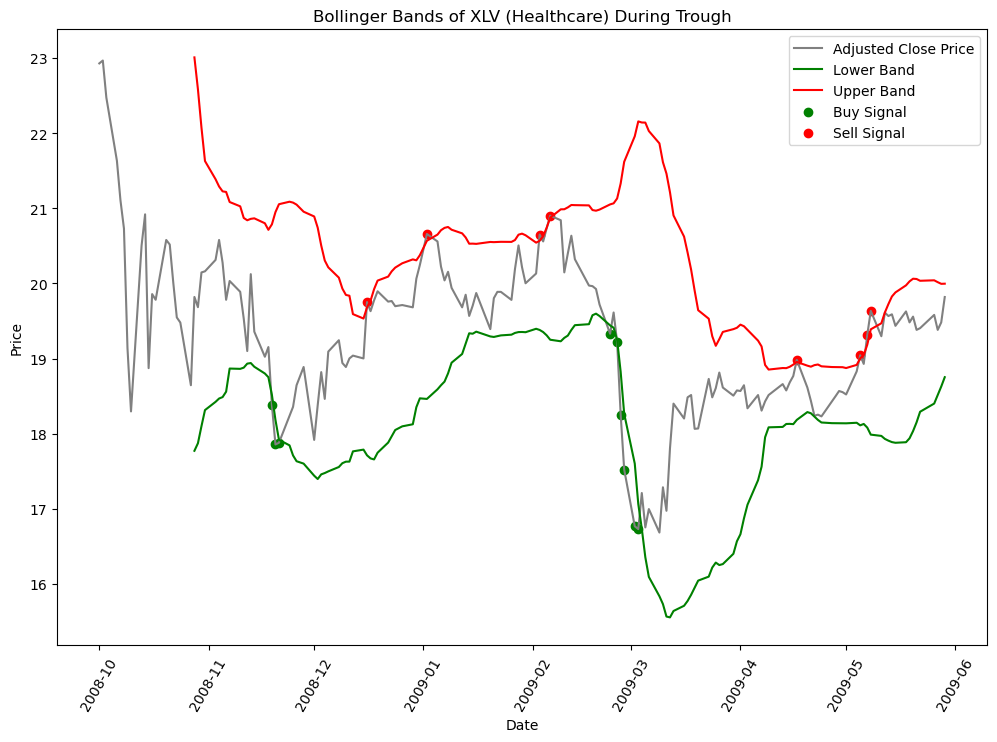

In [22]:
# show the same example but with bollinger bands plotted for XLV during trough
plot_with_boll_bands(sector_etf_data['trough']['XLV'],'Bollinger Bands of XLV (Healthcare) During Trough')

In [23]:
signals_list = list_signals(sector_etf_data,sector_etf_tickers,economic_cycle_periods_list)
signals_list['trough']['XLV']

{'Buy': [Timestamp('2008-11-19 00:00:00'),
  Timestamp('2008-11-20 00:00:00'),
  Timestamp('2008-11-21 00:00:00'),
  Timestamp('2009-02-23 00:00:00'),
  Timestamp('2009-02-25 00:00:00'),
  Timestamp('2009-02-26 00:00:00'),
  Timestamp('2009-02-27 00:00:00'),
  Timestamp('2009-03-02 00:00:00'),
  Timestamp('2009-03-03 00:00:00')],
 'Sell': [Timestamp('2008-12-16 00:00:00'),
  Timestamp('2009-01-02 00:00:00'),
  Timestamp('2009-02-03 00:00:00'),
  Timestamp('2009-02-06 00:00:00'),
  Timestamp('2009-04-17 00:00:00'),
  Timestamp('2009-05-05 00:00:00'),
  Timestamp('2009-05-07 00:00:00'),
  Timestamp('2009-05-08 00:00:00')]}

This graph shows the movement of the healthcare sector ETF (XLV) during a trough. The buy signals are bought when the stock is locally moving down where as the stock is sold when the stock is moving up locally. There are 9 buy signals and 8 sell signals.

## Stochastic Modeling for Bollinger Bands
To understand Bollinger Bands it is important to test how they perform on return on investments during different periods. Not just once, however it is best to repeat this for a number of times during the same periods using the same sector ETFs this is so you can get a broader understanding of the probability of a specific return on investment occurring.

Parameters
Investment period: 90 days
Collect sector ETF closing price
Collect signals for sector ETF

There will be n random samples of start dates from the macroeconomic cycle which will then perform the Bollinger Band investment strategy for 90 days and return the investment n times to understand the distribution function of returns.

In [24]:
# get the adjusted close price dataframe
sector_etf_closed_price = get_adjusted_closed_price(sector_etf_data,sector_etf_tickers,economic_cycle_periods_list)

In [25]:
# load in the dataframe for the trough time period
sector_etf_closed_price['trough']

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
Date,,,,,,,,,,,
2008-10-01,23.119259,21.858330,12.413445,15.649685,22.589594,18.009504,37.393234,22.927486,36.648033,18.666504,34.011738
2008-10-02,21.458338,20.549883,11.794875,15.037062,21.771841,17.782761,35.261135,22.965387,35.561871,18.395735,31.759171
2008-10-03,21.247200,20.222771,11.278402,14.822248,21.010748,17.640240,34.840702,22.472723,35.039391,18.119310,30.064137
2008-10-06,20.198570,19.692123,10.689853,14.002768,20.419704,17.128456,32.966820,21.631426,33.396400,17.233652,29.512159
2008-10-07,19.156965,19.037905,9.560818,13.286716,19.108044,16.584291,31.159033,21.108452,31.966505,16.528521,27.019823
...,...,...,...,...,...,...,...,...,...,...,...
2009-05-22,18.848709,16.073526,7.178296,13.618089,18.520388,15.070189,29.497353,19.404518,33.037407,14.918157,18.541615
2009-05-26,19.300224,16.658962,7.412231,13.971801,19.143751,15.260789,30.122393,19.580992,34.221867,15.351324,19.500563
2009-05-27,18.576380,16.117994,7.190604,13.835136,18.725437,14.873018,29.794701,19.381502,33.881428,15.039443,18.851517


In [26]:
# get the signals for tickers
bb_signals = collect_signals(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)
bb_signals['trough'].iloc[20:40]

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
Date,,,,,,,,,,,
2008-10-29,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008-10-30,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008-10-31,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008-11-03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008-11-04,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008-11-05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008-11-06,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008-11-07,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2008-11-10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [27]:
# save the bollinger band signals
for period in economic_cycle_periods_list:
    bb_signals[period].to_csv(f'/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/signal_data/bollinger_bands/{period}_bollinger_band_signals.csv')

### Base Model
- 20 day period 
- 2 standard deviations
- 5% of balance buy amount
- 20% of shares number sell amount

In [28]:
# stochastic model 1000 times with a $100 investment of the stock
base_bb_average_return = calculate_stock_roi(bb_signals,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,100,0.15,0.20)

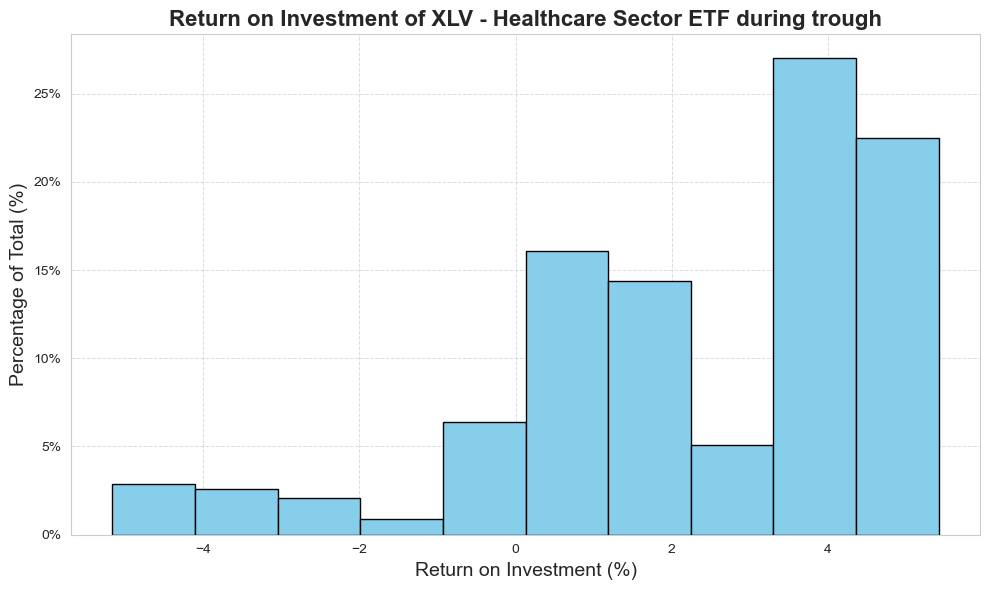

In [29]:
# plot the histogram of the XLV healthcare during a trough
plot_percentage_histogram(
    data=base_bb_average_return['trough']['XLV'],
    title=f'Return on Investment of XLV - Healthcare Sector ETF during trough',
    xlabel='Return on Investment (%)',
        ylabel='Percentage of Total (%)'
)

In [30]:
# get the mean of each stock during each time period
bollinger_band_average_return = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,base_bb_average_return,'Mean')
bollinger_band_average_return

,trough,expansion,peak,contraction,all_data
XLB,4.683427,1.308461,2.085071,0.395056,0.721521
XLI,4.136138,1.593128,1.930251,0.00829,0.679041
XLF,3.30051,1.406383,3.052293,0.937509,0.784879
XLK,2.260457,1.317642,1.485548,-0.696867,0.783995
XLY,5.356835,1.358776,1.578645,1.132198,0.851474
XLP,1.600129,1.171534,0.686564,0.660528,0.704243
XLE,3.585551,0.9845,1.142387,0.332787,0.754024
XLV,2.314417,1.407286,1.068395,-0.184755,0.715161
VOX,6.203114,0.877303,1.428635,-0.981603,0.67533
XLU,-0.25178,0.534986,0.783479,-1.217144,0.393674


In [31]:
bollinger_band_average_return.mean()

trough         3.226073
expansion      1.125228
peak           1.441648
contraction    0.200435
all_data       0.704870
dtype: float64

In [32]:
# save file
bollinger_band_average_return.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/bollinger_band_return.csv')

#### Machine Learning Optimization Model
Bollinger bands are made up of two parameters. The rollign average and confidence interval. These two have a dynamic relationship with one another with their overall impact on the return on investment changing drastically depending on these values. The base model was one where John Bollinger encouraged a 20 day investment period with a 2 standard deviaiton which equates to about 95% confidence interval. This is going to be further investigated using hyperparameter tuning which will test the combination of different discrete sets of values to maximize returns. 

#### Hyperparameter Tuning
Using a list of discrete values for the rolling windows and confidence interval, a grid search can be done to find the optimal values for the maximum return on investment.

In [33]:
grid_search_bollinger_bands = grid_search_bollinger_bands(sector_etf_data,sector_etf_closed_price,param_grid,economic_cycle_periods_list,economic_cycle_periods,sector_etf_tickers,1000,100,0.05,0.2)

In [34]:
grid_search_bollinger_bands.sort_values(by='average_roi',ascending=False)

,rolling_window,confidence_interval,average_roi
12,30,0.90,1.104328
18,50,0.90,1.078383
15,40,0.90,1.009304
9,25,0.90,0.976942
19,50,0.95,0.825966
6,20,0.90,0.781280
3,15,0.90,0.735728
16,40,0.95,0.724568
13,30,0.95,0.714257
10,25,0.95,0.636779


In [35]:
# have to create the relevant data to be put into the optimized average return

optimized_sector_etf_data = bollinger_data_multiple_periods_tickers(economic_cycle_periods_list,sector_etf_tickers,sector_etf_data,30,0.90)
optimized_signals = collect_signals(optimized_sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

In [44]:
optimizied_bb_average_return = calculate_stock_roi(optimized_signals,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,100,0.05,0.20)

In [45]:
# get the average return
optimized_average_returns = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,optimizied_bb_average_return,'Mean')
optimized_average_returns

,trough,expansion,peak,contraction,all_data
XLB,4.298978,0.68889,0.65088,0.231593,0.349621
XLI,3.32693,0.881269,1.055708,0.012671,0.208831
XLF,3.318285,0.871259,0.919543,0.287882,0.250299
XLK,2.656225,0.549948,0.700794,-0.529467,0.468983
XLY,4.800668,0.799966,1.155949,0.964417,0.498931
XLP,0.988139,0.62327,0.298897,0.552297,0.402143
XLE,1.818615,0.100439,0.62411,-0.000543,0.111895
XLV,1.438646,0.751353,0.798749,-0.163054,0.347103
VOX,3.899533,0.599251,0.857679,-0.508155,0.329645
XLU,0.866509,0.39627,0.583744,-0.672219,0.350613


In [46]:
optimized_average_returns.mean()

trough         2.850300
expansion      0.606541
peak           0.737284
contraction    0.121947
all_data       0.326109
dtype: float64

In [47]:
bollinger_band_average_return.mean()

trough         3.226073
expansion      1.125228
peak           1.441648
contraction    0.200435
all_data       0.704870
dtype: float64

In [40]:
# import buy and hold data
benchmark_buy_hold = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/buy_hold_average_return.csv')
benchmark_buy_hold.set_index('Unnamed: 0', inplace=True)
benchmark_buy_hold.index.name=None
benchmark_buy_hold

,trough,expansion,peak,contraction,all_data
XLB,-1.589956,5.013389,3.974372,0.046279,3.792480
XLI,-13.582879,6.495831,6.696004,-4.235029,4.096582
XLF,-22.394564,7.468439,9.382010,-15.121595,2.712771
XLK,3.022472,5.504963,12.351104,-2.864544,5.456580
XLY,-1.400765,7.201352,3.306258,-3.941134,4.190092
XLP,-8.312499,5.831431,5.076035,0.472618,3.360803
XLE,-4.811072,3.772788,-0.698204,3.800582,3.690161
XLV,-4.625084,9.188304,8.315255,-4.025136,3.913920
VOX,4.118390,5.516350,6.005721,-5.608378,3.423958
XLU,-8.548700,4.999544,6.267995,-2.875095,3.264002


In [41]:
# compare the performance
performance_against_benchmark_return = bollinger_band_average_return - benchmark_buy_hold
performance_against_benchmark_return

,trough,expansion,peak,contraction,all_data
XLB,6.273383,-3.704927,-1.889302,0.348777,-3.070959
XLI,17.719016,-4.902704,-4.765753,4.24332,-3.417541
XLF,25.695073,-6.062055,-6.329717,16.059104,-1.927892
XLK,-0.762015,-4.187321,-10.865556,2.167677,-4.672586
XLY,6.7576,-5.842576,-1.727613,5.073332,-3.338618
XLP,9.912627,-4.659897,-4.389471,0.18791,-2.65656
XLE,8.396624,-2.788288,1.840591,-3.467795,-2.936137
XLV,6.939501,-7.781018,-7.24686,3.840381,-3.198759
VOX,2.084723,-4.639047,-4.577086,4.626775,-2.748628
XLU,8.29692,-4.464558,-5.484515,1.657951,-2.870327


In [42]:
# compare the performance
performance_against_benchmark_return.mean()

trough         10.136774
expansion      -4.822882
peak           -4.467437
contraction     3.302164
all_data       -3.028711
dtype: float64

During times of worse economic periods the bollinger bands perform better. It is likely that when the economy is going down the going in and out at certain momentums performs better than the simple buy and hold as the entire market is decreasing.

In [43]:
bollinger_band_std = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,bb_average_return,'Std')
bollinger_band_std

NameError: name 'bb_average_return' is not defined

In [ ]:
# save the bollinger band standard deviation
bollinger_band_std.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/bollinger_band_std.csv')

In [ ]:
benchmark_std = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/buy_hold_standard_deviation.csv')
benchmark_std.set_index('Unnamed: 0',inplace=True)
benchmark_std.index.name = None
benchmark_std

,trough,expansion,peak,contraction,all_data
XLB,18.310677,5.399944,3.031150,10.716423,11.936855
XLI,12.334949,5.718524,3.199150,7.021627,11.298819
XLF,24.747066,5.865965,4.616728,6.751138,14.886990
XLK,13.332425,4.617696,5.524430,7.895902,10.911397
XLY,15.458515,5.372028,3.159502,6.083716,11.410666
XLP,6.044852,4.494049,1.424609,2.703879,6.032534
XLE,9.936193,8.779992,6.189972,14.934433,15.260428
XLV,5.394791,4.726546,5.742871,6.491399,7.442472
VOX,10.482022,5.282104,3.552914,7.279645,10.522018
XLU,4.695702,6.070292,1.988425,6.594848,7.458776


In [ ]:
# compare the risk between the two
performance_against_benchmark_std = bollinger_band_std - benchmark_std
performance_against_benchmark_std

,trough,expansion,peak,contraction,all_data
XLB,-14.759125,-3.702265,-1.683448,-6.427724,-8.342219
XLI,-6.72615,-3.938935,-2.306672,-4.708378,-8.090404
XLF,-10.627571,-4.212114,-2.562754,-2.198671,-11.364704
XLK,-12.170811,-2.690715,-4.619541,-5.974732,-7.970191
XLY,-11.57129,-3.905371,-2.486664,-4.241712,-8.331008
XLP,-3.696463,-3.113504,-0.648945,-1.716174,-4.53568
XLE,-6.945573,-6.563381,-4.970498,-9.178203,-10.667843
XLV,-2.782048,-3.091501,-4.961385,-4.932836,-5.178306
VOX,-6.538102,-4.070414,-2.602336,-4.237093,-7.976906
XLU,-2.102247,-4.998582,-1.032997,-4.273866,-5.314579


In [ ]:
# look at the risk in investment
performance_against_benchmark_std.mean()

trough        -8.115232
expansion     -4.117550
peak          -2.640275
contraction   -4.861672
all_data      -7.934783
dtype: float64

Overall the bollinger bands perform better during times of troughs and contractions but are much riskier than the standard buy and hold strategy.